In [1]:
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

Updated: 5/1 

## Initilization and Data Loading

In [2]:
import pyspark 
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.window import Window

# need these for the feature generation and UDFs and functions.col for brevity 
from pyspark.sql.functions import pandas_udf, PandasUDFType, col
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StructType, StructField
import pandas as pd
import numpy as np
# from scipy.spatial.distance import cosine  # unused 
from scipy.signal import find_peaks

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("EDA") \
    .getOrCreate()


In [3]:
path = "file:///home/work/Final/Dataset/raw"

file = "/phone/accel/*.txt"
df_phone_a = spark.read.csv(path + file, header=False, inferSchema=True)

file = "/phone/gyro/*.txt"
df_phone_g = spark.read.csv(path + file, header=False, inferSchema=True)

file = "/watch/accel/*.txt"
df_watch_a = spark.read.csv(path + file, header=False, inferSchema=True)

file = "/watch/gyro/*.txt"
df_watch_g = spark.read.csv(path + file, header=False, inferSchema=True)


In [4]:
SAMPLE_RATE = 20 #Hz    # also defined in a UDF!


In [5]:
# print(f"Phone Accel: {df_phone_a.count()}")
# print(f"Phone Gyro: {df_phone_g.count()}")
# print(f"Watch Accel: {df_watch_a.count()}")
# print(f"Watch Gyro: {df_watch_g.count()}")

### Activity Refrence 

| Activity                     | Code |
|-----------------------------|------|
| Walking                     | A    |
| Jogging                     | B    |
| Stairs                      | C    |
| Sitting                     | D    |
| Standing                    | E    |
| Typing                      | F    |
| Brushing Teeth              | G    |
| Eating Soup                 | H    |
| Eating Chips                | I    |
| Eating Pasta                | J    |
| Drinking from Cup           | K    |
| Eating Sandwich             | L    |
| Kicking (Soccer Ball)       | M    |
| Playing Catch w/Tennis Ball| O    |
| Dribbling (Basketball)      | P    |
| Writing                     | Q    |
| Clapping                    | R    |
| Folding Clothes             | S    |

## Cleaning

In [6]:

def clean_df(df): 
    #Rename Cols
    col_map = {'_c0': 'sub_id',
           '_c1': 'activity',
           '_c2': 'time',
           '_c3': 'x',
           '_c4': 'y',
           '_c5': 'z'
          }
    df = df.withColumnsRenamed(col_map)

    #convert z from str to double 
    df = df.withColumn('z', func.regexp_replace("z", ";", "").cast("double"))

    #Sort
    df = df.sort("sub_id", "activity", "time")

    #Drop any na/null 
    count1 = df.count()
    df = df.dropna()
    print(f"rows_dropped: {count1 - df.count()}")

    return df

df_phone_a = clean_df(df_phone_a)
df_phone_g = clean_df(df_phone_g)
df_watch_a = clean_df(df_watch_a)
df_watch_g = clean_df(df_watch_g)



rows_dropped: 0


rows_dropped: 0


rows_dropped: 0


[Stage 37:>                                                         (0 + 4) / 4]

rows_dropped: 0


## Segmenting

Segmenting the samples in to ~10 second segments will let us do some more feature enginering 

3 mins / 10s = 18 segment per activity per subject 

51 subjects * 18 segment = 918 per activity 

16,524 segments across all activities



This should be enough for a classification analysis, if we need more we can shorten the segment length
I also don't know if this is the optimal way to store the segments it might be better to have a list of x,y,z tuples... 
-H

In [7]:
# Segment into 10s of data (200 samples) 

def label_segments(df, num_s):
    """ takes a spark df and num_s (int) returns a df where each row element is a list num_s elements

    df must have cols as named in clean_df()
    """
    window_spec = Window.partitionBy("sub_id", "activity").orderBy("time")

    df = df.withColumn("row_num", func.row_number().over(window_spec))

    # create label for grouping 
    df = df.withColumn("group_id", ((func.col("row_num") - 1) / num_s).cast("int"))

    return df

In [8]:
# UDFs for gen_features 
# I started trying to keep them short and single purpose... but I called find_peaks 5 times
# for the fft features there is one large UDF for 4 features

# Element-wise summation of x, y, z streams
@pandas_udf(ArrayType(DoubleType())) #schema returned 
def sum_xyz_udf(x_col: pd.Series, y_col: pd.Series, z_col: pd.Series) -> pd.Series: #(param: type) -> return type 
    return pd.Series([(np.array(x) + np.array(y) + np.array(z)).tolist() for x, y, z in zip(x_col, y_col, z_col)])

@pandas_udf(IntegerType())
def num_peaks_udf(col: pd.Series) -> pd.Series:
    return col.apply(lambda x: len(find_peaks(np.array(x), distance=10)[0]))

@pandas_udf(IntegerType())
def num_peaks_udf_t_1(col: pd.Series) -> pd.Series:
    return col.apply(lambda x: len(find_peaks(np.array(x), threshold=1)[0]))

@pandas_udf(IntegerType())
def num_peaks_udf_t_pt1(col: pd.Series) -> pd.Series:
    return col.apply(lambda x: len(find_peaks(np.array(x), threshold=0.1)[0]))

@pandas_udf(ArrayType(IntegerType()))
def peak_locs_udf(col: pd.Series) -> pd.Series:
    return col.apply(lambda x: find_peaks(np.array(x), distance=10)[0].tolist())

@pandas_udf(IntegerType())
def sum_peak_locs_udf(col: pd.Series) -> pd.Series:
    return col.apply(lambda x: sum(find_peaks(np.array(x))[0]))


@pandas_udf(StructType([
        StructField("dom_freq", DoubleType()),
        StructField("second_freq", DoubleType()),
        StructField("third_freq", DoubleType()),
        StructField("mean_freq", DoubleType())
    ]))
def fft_features_udf(col: pd.Series) -> pd.DataFrame:
    """ 
    calls a extract feature function that provides top 3 frequencies and the mean freq from a fft
    if fft doesn't find enough freq it returns 0 
    if the values are null there are not enough values in the serries 
    """
    def extract_features(x):
        """
        expects pd.Serries, tuple of 4 doubles: (dom_freq, second_freq, third_freq, mean_freq)
        """
        SAMPLE_RATE = 20 #Hz
        output = 0.0
        # output = None
        
        x = np.array(x)
        if len(x) < 2:
            return (None, None, None, None)
        
        x = x - np.mean(x) #remove offset

        # FFT
        fft_vals = np.fft.fft(x)
        fft_freq = np.fft.fftfreq(len(x), d=1.0/SAMPLE_RATE)

        # Use only the positive spectrum
        pos = fft_freq > 0
        freqs = fft_freq[pos]
        mag_s = np.abs(fft_vals[pos])  # Magnitude spectrum

        if len(mag_s) >= 3: 
            top_freqs = freqs[np.argsort(mag_s)[-3:]]
            
            dom_freq = top_freqs[-1]
            second_freq = top_freqs[-2]
            third_freq = top_freqs[-3]
            
        elif len(mag_s) == 2:
            top_freqs = freqs[np.argsort(mag_s)[-2:]]

            dom_freq = top_freqs[-1]
            second_freq = top_freqs[-2]
            third_freq = output
            
        elif len(mag_s) == 1: 
            top_freqs = freqs[np.argsort(mag_s)[-1:]]

            dom_freq = top_freqs[-1]
            second_freq = output
            third_freq = output
        else: 
            dom_freq = output
            second_freq = output
            third_freq = output

        # Dominant frequency
        # top_freqs = freqs[np.argsort(mag_s)[-3:]] if len(mag_s) > 3 else [None, None, None]
        # dom_freq = top_freqs[-1]
        # second_freq = top_freqs[-2]
        # third_freq = top_freqs[-3]
        # # dom_freq = freqs[np.argmax(mags)] if len(mags) > 0 else None
        
        # Mean freq (weighted)
        mean_freq = np.sum(freqs * mag_s) / np.sum(mag_s) if np.sum(mag_s) > 0 else output

        return (dom_freq, second_freq, third_freq, mean_freq)
    
    return pd.DataFrame(col.apply(extract_features).tolist(), columns=["dom_freq", "second_freq", "third_freq", "mean_freq"])



def gen_features(df): 
    """ takes a spark df

    dfs must have columns "sub_id", "activity", "group_id"
    """
    df = df.groupBy("sub_id", "activity", "group_id").agg(
        func.collect_list("time").alias("time"), 
        func.collect_list("x").alias("x"),
        func.collect_list("y").alias("y"),
        func.collect_list("z").alias("z"), 
        func.avg("x").alias("x_avg"),
        func.avg("y").alias("y_avg"), 
        func.avg("z").alias("z_avg"),
        func.sum("x").alias("x_sum"),
        func.sum("y").alias("y_sum"),
        func.sum("z").alias("z_sum"),
        func.stddev("x").alias("x_stddev"),
        func.stddev("y").alias("y_stddev"),
        func.stddev("z").alias("z_stddev"),
        func.corr("x", "y").alias("corr_x_y"),
        func.corr("x", "z").alias("corr_x_z"),
        func.corr("y", "z").alias("corr_y_z"),
        func.avg( func.sqrt( func.pow("x", 2) + func.pow("y", 2) + func.pow("z", 2))).alias("resultant")
        
    )

    df = df.withColumn("sum_xyz", sum_xyz_udf("x", "y", "z"))
    
    # find_peaks 
    df = df.withColumn("x_num_peaks", num_peaks_udf("x")) \
    .withColumn("x_num_peaks_t_1", num_peaks_udf_t_1('x')) \
    .withColumn("x_num_peaks_t_pt1", num_peaks_udf_t_pt1('x'))

    df = df.withColumn("y_num_peaks", num_peaks_udf("y")) \
    .withColumn("y_num_peaks_t_1", num_peaks_udf_t_1('y')) \
    .withColumn("y_num_peaks_t_pt1", num_peaks_udf_t_pt1('y'))

    df = df.withColumn("z_num_peaks", num_peaks_udf("z")) \
    .withColumn("z_num_peaks_t_1", num_peaks_udf_t_1('z')) \
    .withColumn("z_num_peaks_t_pt1", num_peaks_udf_t_pt1('z'))

    df = df.withColumn("xyz_num_peaks", num_peaks_udf("sum_xyz")) \
    .withColumn("xyz_num_peaks_t_1", num_peaks_udf_t_1('sum_xyz')) \
    .withColumn("xyz_num_peaks_t_pt1", num_peaks_udf_t_pt1('sum_xyz'))

    # might have some information on where in the segment the peaks are found relative
    df = df.withColumn("x_avg_peak_locs", sum_peak_locs_udf("x")/col("x_num_peaks")) \
    .withColumn("y_avg_peak_locs", sum_peak_locs_udf("y")/col("y_num_peaks")) \
    .withColumn("z_avg_peak_locs", sum_peak_locs_udf("z")/col("z_num_peaks")) \
    .withColumn("xyz_avg_peak_locs", sum_peak_locs_udf("sum_xyz")/col("xyz_num_peaks")) \
    
    
    # frequency features 
    # each block unpacks the udf results into 4 features 
    df = df.withColumn("x_fft", fft_features_udf("x")) \
        .withColumn("x_dom_freq", func.col("x_fft.dom_freq")) \
        .withColumn("x_2nd_freq", func.col("x_fft.second_freq")) \
        .withColumn("x_3rd_freq", func.col("x_fft.third_freq")) \
        .withColumn("x_mean_freq", func.col("x_fft.mean_freq")) \
        .drop("x_fft")

    df = df.withColumn("y_fft", fft_features_udf("y")) \
        .withColumn("y_dom_freq", func.col("y_fft.dom_freq")) \
        .withColumn("y_2nd_freq", func.col("y_fft.second_freq")) \
        .withColumn("y_3rd_freq", func.col("y_fft.third_freq")) \
        .withColumn("y_mean_freq", func.col("y_fft.mean_freq")) \
        .drop("y_fft")

    df = df.withColumn("z_fft", fft_features_udf("z")) \
        .withColumn("z_dom_freq", func.col("z_fft.dom_freq")) \
        .withColumn("z_2nd_freq", func.col("z_fft.second_freq")) \
        .withColumn("z_3rd_freq", func.col("z_fft.third_freq")) \
        .withColumn("z_mean_freq", func.col("z_fft.mean_freq")) \
        .drop("z_fft")
    
    df = df.withColumn("xyz_fft", fft_features_udf("sum_xyz")) \
        .withColumn("xyz_dom_freq", func.col("xyz_fft.dom_freq")) \
        .withColumn("xyz_2nd_freq", func.col("xyz_fft.second_freq")) \
        .withColumn("xyz_3rd_freq", func.col("xyz_fft.third_freq")) \
        .withColumn("xyz_mean_freq", func.col("xyz_fft.mean_freq")) \
        .drop("xyz_fft")
    
    return df



SECONDS = 10

df_phone_a_seg = gen_features(label_segments(df_phone_a, SAMPLE_RATE*SECONDS))
df_phone_g_seg = gen_features(label_segments(df_phone_g, SAMPLE_RATE*SECONDS))
df_watch_a_seg = gen_features(label_segments(df_watch_a, SAMPLE_RATE*SECONDS))
df_watch_g_seg = gen_features(label_segments(df_watch_g, SAMPLE_RATE*SECONDS))



# df_phone_a_seg.show()

In [9]:
df_phone_a_seg.printSchema()

root
 |-- sub_id: integer (nullable = true)
 |-- activity: string (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- time: array (nullable = false)
 |    |-- element: long (containsNull = false)
 |-- x: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- y: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- z: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- x_avg: double (nullable = true)
 |-- y_avg: double (nullable = true)
 |-- z_avg: double (nullable = true)
 |-- x_sum: double (nullable = true)
 |-- y_sum: double (nullable = true)
 |-- z_sum: double (nullable = true)
 |-- x_stddev: double (nullable = true)
 |-- y_stddev: double (nullable = true)
 |-- z_stddev: double (nullable = true)
 |-- corr_x_y: double (nullable = true)
 |-- corr_x_z: double (nullable = true)
 |-- corr_y_z: double (nullable = true)
 |-- resultant: double (nullable = true)
 |-- sum_xyz: array (nullable = true)
 |   

In [10]:
# df_phone_a_seg.select("activity",
#                       "x_num_peaks", 
#                       "y_num_peaks",
#                       "z_num_peaks",
#                       "xyz_num_peaks").show(20)

In [11]:
# df_phone_a_seg.select("activity",
#                       "x_num_peaks_t_pt1",
#                       "y_num_peaks_t_pt1", 
#                       "z_num_peaks_t_pt1",
#                       "xyz_num_peaks_t_pt1").show(20)

In [12]:
def count_nulls(df):
    return df.groupby("activity").agg(
        func.sum(col("x_dom_freq").isNull().cast("int")).alias("x_dom_freq_nul"),
        func.sum(col("x_2nd_freq").isNull().cast("int")).alias("x_2nd_freq" + "_nul"),
        func.sum(col("x_mean_freq").isNull().cast("int")).alias("x_mean_freq" + "_nul"),
        func.sum(col("y_dom_freq").isNull().cast("int")).alias("y_dom_freq" + "_nul"),
        func.sum(col("y_2nd_freq").isNull().cast("int")).alias("y_2nd_freq" + "_nul"),
        func.sum(col("y_mean_freq").isNull().cast("int")).alias("y_mean_freq" + "_nul"),
        func.sum(col("z_dom_freq").isNull().cast("int")).alias("z_dom_freq" + "_nul"),
        func.sum(col("z_2nd_freq").isNull().cast("int")).alias("z_2nd_freq" + "_nul"),
        func.sum(col("z_mean_freq").isNull().cast("int")).alias("z_mean_freq" + "_nul"),
        func.sum(col("xyz_dom_freq").isNull().cast("int")).alias("xyz_dom_freq" + "_nul"),
        func.sum(col("xyz_2nd_freq").isNull().cast("int")).alias("xyz_2nd_freq" + "_nul"),
        func.sum(col("xyz_mean_freq").isNull().cast("int")).alias("xyz_mean_freq" + "_nul")

    ).sort("activity")
count_nulls(df_phone_a_seg).show()
count_nulls(df_watch_a_seg).show()
count_nulls(df_phone_g_seg).show()
count_nulls(df_watch_g_seg).show()


+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|activity|x_dom_freq_nul|x_2nd_freq_nul|x_mean_freq_nul|y_dom_freq_nul|y_2nd_freq_nul|y_mean_freq_nul|z_dom_freq_nul|z_2nd_freq_nul|z_mean_freq_nul|xyz_dom_freq_nul|xyz_2nd_freq_nul|xyz_mean_freq_nul|
+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|       A|             2|             2|              2|             2|             2|              2|             2|             2|              2|               2|               2|                2|
|       B|             3|             3|              3|             3|             3|              3|             3|             3|              3|               3|               3|              

+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|activity|x_dom_freq_nul|x_2nd_freq_nul|x_mean_freq_nul|y_dom_freq_nul|y_2nd_freq_nul|y_mean_freq_nul|z_dom_freq_nul|z_2nd_freq_nul|z_mean_freq_nul|xyz_dom_freq_nul|xyz_2nd_freq_nul|xyz_mean_freq_nul|
+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|       A|             7|             7|              7|             7|             7|              7|             7|             7|              7|               7|               7|                7|
|       B|             6|             6|              6|             6|             6|              6|             6|             6|              6|               6|               6|              

+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|activity|x_dom_freq_nul|x_2nd_freq_nul|x_mean_freq_nul|y_dom_freq_nul|y_2nd_freq_nul|y_mean_freq_nul|z_dom_freq_nul|z_2nd_freq_nul|z_mean_freq_nul|xyz_dom_freq_nul|xyz_2nd_freq_nul|xyz_mean_freq_nul|
+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|       A|             0|             0|              0|             0|             0|              0|             0|             0|              0|               0|               0|                0|
|       B|             0|             0|              0|             0|             0|              0|             0|             0|              0|               0|               0|              

[Stage 79:==============================================>           (4 + 1) / 5]

+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|activity|x_dom_freq_nul|x_2nd_freq_nul|x_mean_freq_nul|y_dom_freq_nul|y_2nd_freq_nul|y_mean_freq_nul|z_dom_freq_nul|z_2nd_freq_nul|z_mean_freq_nul|xyz_dom_freq_nul|xyz_2nd_freq_nul|xyz_mean_freq_nul|
+--------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+----------------+----------------+-----------------+
|       A|             1|             1|              1|             1|             1|              1|             1|             1|              1|               1|               1|                1|
|       B|             1|             1|              1|             1|             1|              1|             1|             1|              1|               1|               1|              

In [13]:
# # confirms nulls are from the leftover data that isn't handled with segmenting

# min_samples = SAMPLE_RATE*SECONDS

# filtered_df = df_phone_g_seg.filter(func.size(col("x")) == min_samples)

# count_nulls(filtered_df).show()

In [14]:
## Remove row that have too few samples 

min_samples = SAMPLE_RATE*SECONDS

df_phone_a_seg = df_phone_a_seg.filter(func.size(col("x")) == min_samples)
df_phone_g_seg = df_phone_g_seg.filter(func.size(col("x")) == min_samples)
df_watch_a_seg = df_watch_a_seg.filter(func.size(col("x")) == min_samples)
df_watch_g_seg = df_watch_g_seg.filter(func.size(col("x")) == min_samples)

In [15]:



def freq_sum(df):
    return df.select("x_avg",
              "x_dom_freq",
              "x_2nd_freq",
              "x_3rd_freq", 
              "x_mean_freq",
              "y_dom_freq",
              "y_2nd_freq",
              "y_3rd_freq", 
              "y_mean_freq",
              "z_dom_freq",
              "z_2nd_freq",
              "z_3rd_freq", 
              "z_mean_freq",
              "xyz_dom_freq",
              "xyz_2nd_freq",
              "xyz_3rd_freq", 
              "xyz_mean_freq"
                    ).summary().show()

freq_sum(df_phone_a_seg) 
# freq_sum(df_phone_g_seg)   
# freq_sum(df_watch_a_seg) 
# freq_sum(df_watch_g_seg) 


[Stage 90:==============================================>           (4 + 1) / 5]

+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|              x_avg|        x_dom_freq|         x_2nd_freq|        x_3rd_freq|       x_mean_freq|        y_dom_freq|         y_2nd_freq|        y_3rd_freq|       y_mean_freq|        z_dom_freq|        z_2nd_freq|        z_3rd_freq|       z_mean_freq|      xyz_dom_freq|       xyz_2nd_freq|      xyz_3rd_freq|     xyz_mean_freq|
+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+---------

## Summary Stats and Plots 

In [16]:
# sum stats for groups 

def sum_stats(df):
    tot = df.count()
    # group by activity, agg stddev (x,y,z), avg (x,y,z), and resultant
    df = df.groupBy("activity").agg(
        func.avg("x_avg").alias("x_avg"),
        func.avg("x_stddev").alias("x_std_avg"),
        func.avg("y_avg").alias("y_avg"),
        func.avg("y_stddev").alias("y_std_avg"),
        func.avg("z_avg").alias("z_avg"),
        func.avg("z_stddev").alias("z_std_avg"),
        func.avg("resultant").alias("resultant_avg"),
        func.avg("xyz_dom_freq").alias("dom_freq_avg"),
        func.avg("xyz_mean_freq").alias("mean_freq_avg"),
        func.avg("xyz_num_peaks").alias("num_peaks"),
        func.avg("xyz_num_peaks_t_1").alias("num_peaks_1"),
        func.avg("xyz_num_peaks_t_pt1").alias("num_peaks_2"),
        func.count("group_id").alias("num_seg")
        ).sort("activity") 
    
    for c in df.columns:
        if c == "activity":
            df = df.withColumn(c, col(c))
        elif c == "num_seg":
            df = df.withColumn(c, col(c))
            df = df.withColumn("percent", func.round(100*col(c)/tot, 2) )
        else:
            df = df.withColumn(c, func.round(c, 2))
            
            

    return df 

df_sum_stats_phone_a = sum_stats(df_phone_a_seg)
df_sum_stats_phone_g = sum_stats(df_phone_g_seg)
df_sum_stats_watch_a = sum_stats(df_watch_a_seg)
df_sum_stats_watch_g = sum_stats(df_watch_g_seg)

print("phone_a")
df_sum_stats_phone_a.show()
print("phone_g")
df_sum_stats_phone_g.show()
print("watch_a")
df_sum_stats_watch_a.show()
print("watch_g")
df_sum_stats_watch_g.show()

phone_a


+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|activity|x_avg|x_std_avg|y_avg|y_std_avg|z_avg|z_std_avg|resultant_avg|dom_freq_avg|mean_freq_avg|num_peaks|num_peaks_1|num_peaks_2|num_seg|percent|
+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|       A| 0.97|     3.46|-2.31|     3.62|-0.16|     3.41|        10.89|        1.51|          3.8|    14.44|      23.87|      38.79|   1364|   5.83|
|       B| 0.23|     6.92|-2.83|     8.39| 0.09|     5.76|        13.28|        1.95|         3.99|    13.46|      31.03|      39.59|   1309|   5.59|
|       C| 0.21|     2.78|-3.34|     3.32|-0.61|     2.68|         10.3|        1.26|         3.58|    14.32|      19.86|      37.39|   1243|   5.31|
|       D|-0.13|      0.2| -0.9|     0.19| 0.43|      0.2|         9.73|        1.35|         3.53| 

+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|activity|x_avg|x_std_avg|y_avg|y_std_avg|z_avg|z_std_avg|resultant_avg|dom_freq_avg|mean_freq_avg|num_peaks|num_peaks_1|num_peaks_2|num_seg|percent|
+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|       A|  0.0|     1.25| 0.01|     1.41|-0.01|     0.89|         1.94|        1.53|          3.7|    14.29|      11.65|       35.7|    984|   5.66|
|       B|-0.03|     2.03|-0.03|     2.24|-0.02|     1.61|         3.14|        2.09|         4.16|    13.52|      23.95|      42.71|    967|   5.56|
|       C| 0.01|     1.12|-0.02|     1.18|  0.0|      0.8|         1.65|        0.99|         3.22|     14.2|       6.82|      32.09|    953|   5.48|
|       D|  0.0|     0.07|  0.0|     0.07|  0.0|     0.07|         0.09|        1.28|         3.15| 

+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|activity|x_avg|x_std_avg|y_avg|y_std_avg|z_avg|z_std_avg|resultant_avg|dom_freq_avg|mean_freq_avg|num_peaks|num_peaks_1|num_peaks_2|num_seg|percent|
+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|       A|  5.6|     3.54|-3.93|     3.01| 0.13|     2.61|        11.47|        1.32|         3.51|    14.78|      20.02|      37.85|   1048|   5.57|
|       B| 1.11|     8.72|-6.99|     10.0|-0.47|     5.85|        15.49|        1.56|         3.59|    13.58|      29.89|      38.02|   1025|   5.45|
|       C| 5.62|     3.97|-3.62|     2.93| 0.39|     2.61|        10.61|        1.05|         3.27|    14.45|      18.31|      36.34|   1032|   5.49|
|       D| 0.63|     0.51|-2.92|     0.69| 5.24|     0.59|         9.79|        1.19|         3.78| 

[Stage 178:==================================>                      (3 + 2) / 5]

+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|activity|x_avg|x_std_avg|y_avg|y_std_avg|z_avg|z_std_avg|resultant_avg|dom_freq_avg|mean_freq_avg|num_peaks|num_peaks_1|num_peaks_2|num_seg|percent|
+--------+-----+---------+-----+---------+-----+---------+-------------+------------+-------------+---------+-----------+-----------+-------+-------+
|       A|-0.02|     1.76|  0.0|     1.07|-0.01|     2.06|         2.65|        1.04|         2.64|     13.5|       4.45|       23.7|    954|    5.6|
|       B|-0.25|     2.26|-0.02|     2.64| 0.03|      2.5|         3.95|         1.6|         3.74|    13.62|      21.05|      41.19|    930|   5.46|
|       C|-0.02|     1.82|-0.02|     1.03|-0.01|     1.58|         2.27|        0.89|         2.79|    13.56|       5.03|      26.43|    896|   5.26|
|       D|  0.0|     0.29|  0.0|     0.15|  0.0|     0.15|         0.25|        1.59|         3.66| 

In [17]:
# spark.stop()

In [18]:
import matplotlib.pyplot as plt
col = func.col

In [19]:
# Extract arrays for example activities   
df_filtered = df_phone_a_seg.filter(
    ((col("sub_id") == 1600) & (col("activity") == "A") & (col("group_id") == 1)) |
    ((col("sub_id") == 1600) & (col("activity") == "B") & (col("group_id") == 1)) |
    ((col("sub_id") == 1600) & (col("activity") == "D") & (col("group_id") == 1))
)
data = df_filtered.collect()

plot_data = {}
for row in data:
    plot_data[row['activity']] = {
        "x": row["x"],
        "y": row["y"],
        "z": row["z"],
        "xyz": row['sum_xyz']
    }

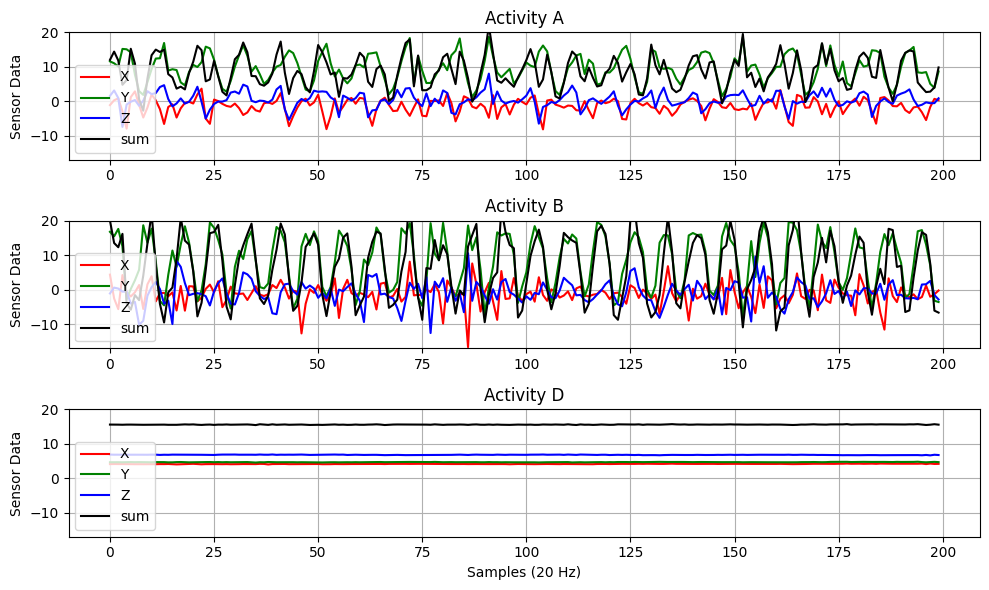

In [20]:
# plot example activities 
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

x = range(0,200)

for ax, (key, data) in zip(axes, plot_data.items()):
    ax.plot(x, data["x"], label="X", color="red")
    ax.plot(x, data["y"], label="Y", color="green")
    ax.plot(x, data["z"], label="Z", color="blue")
    ax.plot(x, data["xyz"], label="sum", color="black")
    ax.set_title(f"Activity {key}")
    ax.grid()
    ax.set_ylim((-17, 20))
    ax.set_ylabel("Sensor Data")
    ax.legend()

axes[-1].set_xlabel("Samples (20 Hz)")

plt.tight_layout()
plt.show()

In [21]:
# Extract arrays for walking from all sensor dfs

data = []
data.append(df_phone_a_seg.filter(
    ((col("sub_id") == 1600) & (col("activity") == "A") & (col("group_id") == 1)) ).collect() )

data.append(df_watch_a_seg.filter(
    ((col("sub_id") == 1600) & (col("activity") == "A") & (col("group_id") == 1)) ).collect() )

data.append(df_phone_g_seg.filter(
    ((col("sub_id") == 1600) & (col("activity") == "A") & (col("group_id") == 1)) ).collect() )


data.append(df_watch_g_seg.filter(
    ((col("sub_id") == 1600) & (col("activity") == "A") & (col("group_id") == 1)) ).collect() )

# print(len(data))

datasets = ["Phone Accelerometer", "Watch Accelerometer", "Phone Gyroscope", "Watch Gyroscope"]


plot2_data = {}
for row, name in zip(data, datasets):
    # print(len(row))
    plot2_data[name] = {
        "x": row[0]["x"],
        "y": row[0]["y"],
        "z": row[0]["z"]
    }

plot2_data.keys()

dict_keys(['Phone Accelerometer', 'Watch Accelerometer', 'Phone Gyroscope', 'Watch Gyroscope'])

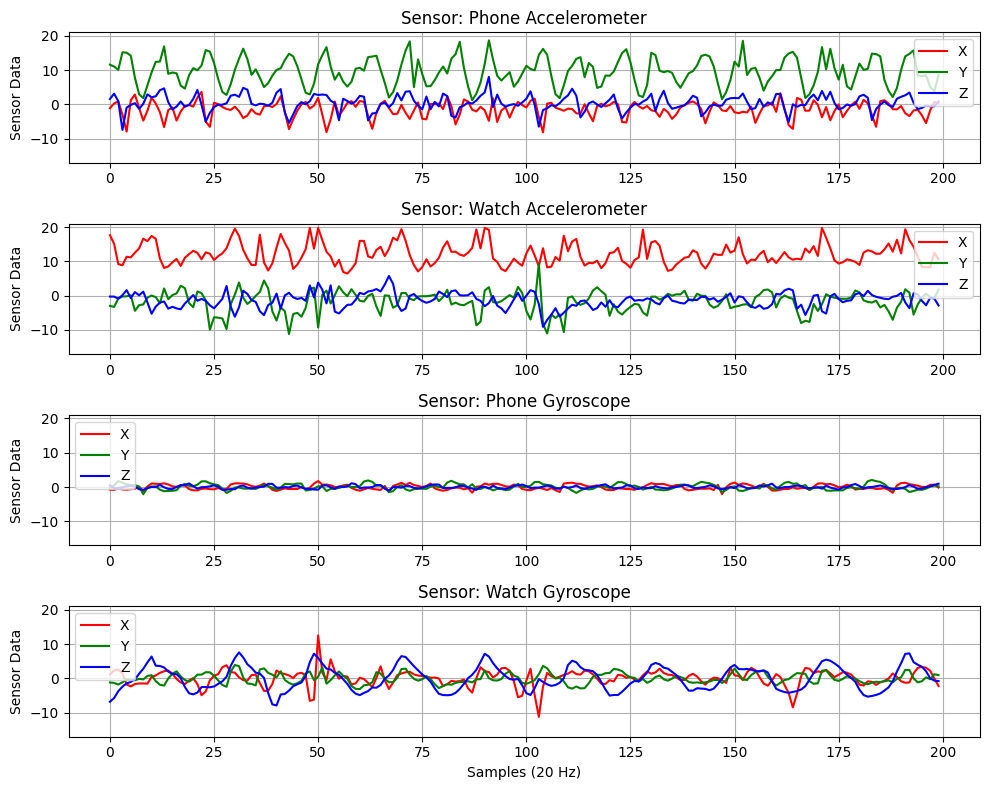

In [22]:
fig2, axes2 = plt.subplots(4, 1, figsize=(10, 8))

x = range(0,200)

for ax, (key, data) in zip(axes2, plot2_data.items()):
    ax.plot(x, data["x"], label="X", color="red")
    ax.plot(x, data["y"], label="Y", color="green")
    ax.plot(x, data["z"], label="Z", color="blue")
    ax.set_title(f"Sensor: {key}")
    ax.grid()
    ax.set_ylim((-17, 21))
    ax.set_ylabel("Sensor Data")
    ax.legend()

axes2[-1].set_xlabel("Samples (20 Hz)")

plt.tight_layout()
plt.show()


In [31]:
# Select a df with sub_id, activity, and generated features (numeric cols)
numeric_cols = [field.name for field in df_watch_a_seg.schema.fields if isinstance(field.dataType, IntegerType) or isinstance(field.dataType, DoubleType)]
to_select = ["activity"] + numeric_cols 


pddf_phone_a = df_phone_a_seg.select(numeric_cols).toPandas()
pddf_watch_a = df_watch_a_seg.select(numeric_cols).toPandas()
pddf_phone_g = df_phone_g_seg.select(numeric_cols).toPandas()
pddf_watch_g = df_watch_g_seg.select(numeric_cols).toPandas()




In [38]:
#Save CSV for future work 
path = "/home/work/Final/features_"

pddf_phone_a.to_csv(path+"phone_a"+".csv", index=False)
pddf_watch_a.to_csv(path+"watch_a"+".csv", index=False) 
pddf_phone_g.to_csv(path+"phone_g"+".csv", index=False) 
pddf_watch_g.to_csv(path+"watch_g"+".csv", index=False) 
